In [1]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        
from imap.data.image_rendering_data_module import ImageRenderingDataModule
from imap.model.nerf import NERF
from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import os
from pathlib import Path
import torch
from tqdm.notebook import tqdm
from evo.core.trajectory import PosePath3D

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load images

In [3]:
color_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/rgb/1305031464.959763.png"))
depth_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/depth/1305031464.952471.png"))

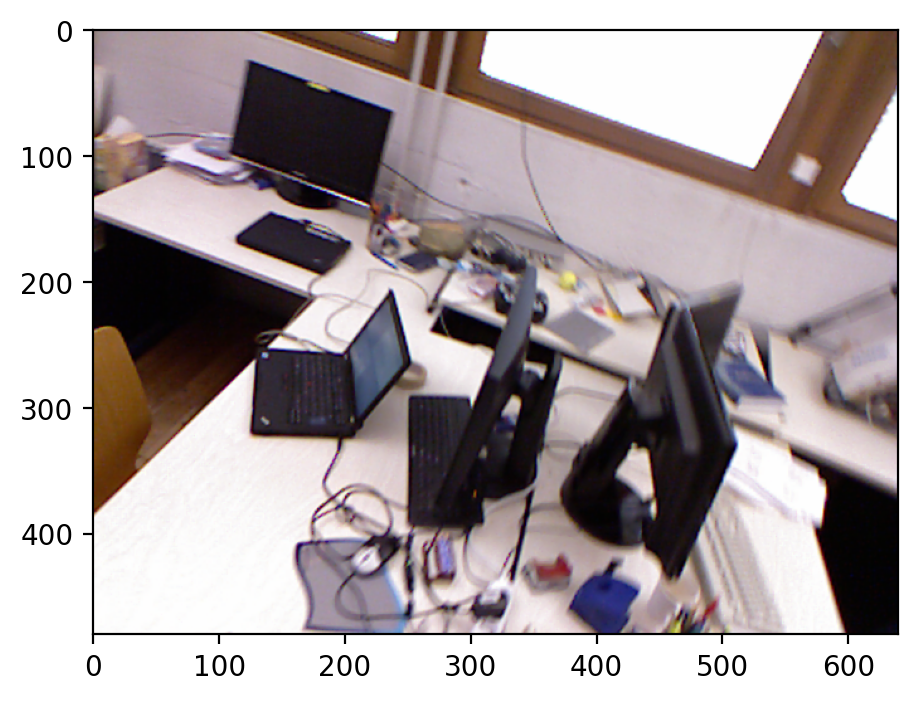

In [4]:
figure = plt.figure(dpi=200)
color_image = cv2.imread(color_image_path)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))

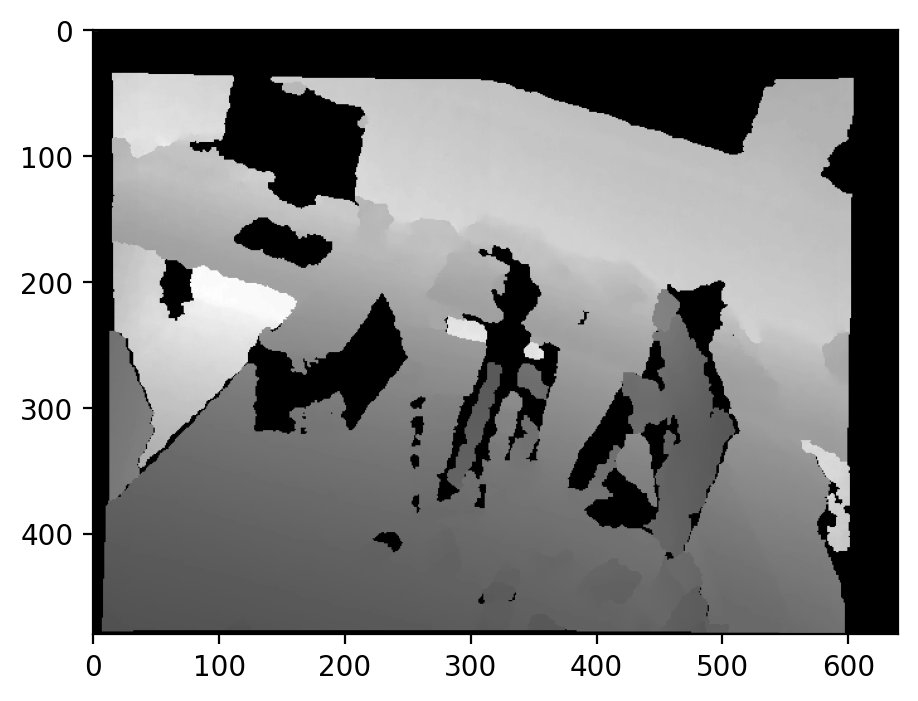

In [5]:
figure = plt.figure(dpi=200)
depth_image = cv2.imread(depth_image_path, -1).astype(np.float32) / 5000
depth_image = np.clip(depth_image, 0, 4)
plt.imshow(depth_image, cmap="gray")

In [6]:
dataset_params = {'dataset_path': "/media/mikhail/Data3T/tum_rgbd", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [131, 257, 325, 407, 455],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
# dataset_params=1
data_module = ImageRenderingDataModule('tum', **dataset_params)

Reading /media/mikhail/Data3T/tum_rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt
Read (5, 480, 640, 3) images array
Dataset size: 1536000 pixels
[ToyDataModule] - train subset size 1536000


In [39]:
parameters = AttributeDict(
    name="NERF",
    optimizer=AttributeDict(lr=0.005),
    encoding_dimension=93,
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    encoding_sigma=25,
    optimize_positions=False,
    minimal_depth=0.01,
)
factory = UniversalFactory([NERF])
model = factory.make_from_parameters(parameters, camera_info=data_module.camera_info())

# SLAM

In [40]:
from imap.slam.imap_data_loader import IMAPDataLoader
from imap.slam.active_sampler import ActiveSampler
from imap.slam.keyframe_validator import KeyframeValidator
from imap.slam.imap_map_builder import IMAPMapBuilder
from imap.slam.imap_tracker import IMAPTracker
from imap.data.tum_frame_loader import TUMFrameLoader
from imap.slam.posed_frame import PosedFrame
from imap.slam.optimized_frame import OptimizedFrame

In [41]:
dataset_path = "/media/mikhail/Data3T/tum_rgbd"
scene_name = "rgbd_dataset_freiburg1_desk"
association_file_name = "data_association_file.txt"
camera_info = data_module._dataset._camera_info
map_builder_data_loader = IMAPDataLoader(20, 200, camera_info)

sampler_data_loader = IMAPDataLoader(1, 200, camera_info)
sampler = ActiveSampler(sampler_data_loader, 4, 1)

keyframe_validator = KeyframeValidator(0.1, 0.5)
builder = IMAPMapBuilder(model, map_builder_data_loader, sampler, keyframe_validator)
frames = TUMFrameLoader(dataset_path, scene_name, association_file_name, range(0, 20, 1))

initial_position = np.eye(4)[:3, :]
frames = [OptimizedFrame(x, initial_position, lr=0.005) for x in frames]

tracker_data_loader = IMAPDataLoader(20, 200, data_module.camera_info())
tracker = IMAPTracker(model, tracker_data_loader)

Reading /media/mikhail/Data3T/tum_rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [42]:
# previous_frame = frames[0]
# previous_frame.position.requires_grad_(False)
# builder.set_current_frame(previous_frame)
# for i in range(10):
#     builder.step()
# tracker.update_model(model)

# frame = frames[5]
# for i in range(10):
#     tracker.track(frame)

In [43]:
previous_frame = frames[0]
previous_frame.position.requires_grad_(False)
builder.set_current_frame(previous_frame)
for i in range(10):
    builder.step()

tracker.update_model(model)
    
velocity = torch.zeros(9, dtype=torch.float32, device="cuda")

tracked_positions = []
i = 1
for frame in tqdm(frames[1:]):
    print(f"------------- Iteration {i} ---------------")
    previous_position = previous_frame.position.detach().clone()
    frame.position.data = (previous_position + velocity).requires_grad_(True)
    tracker.track(frame)
    tracked_position = frame.position.detach().clone()
    
#     velocity = 0.2 * velocity + 0.8 * (tracked_position - previous_position)
    tracked_positions.append(frame.position)
    if i % 5 == 0:
        builder.set_current_frame(frame)
        builder.step()
        tracker.update_model(model)
    previous_frame = frame
    i += 1

Map builder step
Start training
Final loss = 1.4126485586166382
Keyframe validator criterion = 0.45180722891566266
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.8056623935699463
Keyframe validator criterion = 0.4342857142857143
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.6439784169197083
Keyframe validator criterion = 0.42168674698795183
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.6101841330528259
Keyframe validator criterion = 0.5087719298245614
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5592186450958252
Keyframe validator criterion = 0.4444444444444444
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.6163110136985779
Keyframe validator criterion = 0.43452380952380953
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.5700648427009583
Keyframe validator criterion = 0.5116279069767442
Keyframe is validated = 

  0%|          | 0/19 [00:00<?, ?it/s]

------------- Iteration 1 ---------------
Tracker step
Start training
Final loss = 0.5142421722412109
------------- Iteration 2 ---------------
Tracker step
Start training
Final loss = 0.5488490462303162
------------- Iteration 3 ---------------
Tracker step
Start training
Final loss = 0.5571014881134033
------------- Iteration 4 ---------------
Tracker step
Start training
Final loss = 0.7077481746673584
------------- Iteration 5 ---------------
Tracker step
Start training
Final loss = 0.5700334310531616
Map builder step
Start training
Final loss = 0.5531564354896545
Keyframe validator criterion = 0.4124293785310734
Keyframe is validated = True
------------- Iteration 6 ---------------
Tracker step
Start training
Final loss = 0.6330440640449524
------------- Iteration 7 ---------------
Tracker step
Start training
Final loss = 0.688233494758606
------------- Iteration 8 ---------------
Tracker step
Start training
Final loss = 0.5847351551055908
------------- Iteration 9 ---------------


In [44]:
len(builder._keyframes)

4

In [45]:
import plotly.graph_objects as go
def show_trajectories(shown_truth_trajectory, shown_predicted_trajectory):
    fig = go.Figure(
        data=[
            go.Scatter3d(x=shown_truth_trajectory[:, 0],
                         y=shown_truth_trajectory[:, 1], 
                         z=shown_truth_trajectory[:, 2],
                         mode="markers",
                         name="truth",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=shown_predicted_trajectory[:, 0],
                         y=shown_predicted_trajectory[:, 1],
                         z=shown_predicted_trajectory[:, 2],
                         mode="markers",
                         name="predicted",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=make_lines(shown_truth_trajectory[:, 0], shown_predicted_trajectory[:, 0]),
                         y=make_lines(shown_truth_trajectory[:, 1], shown_predicted_trajectory[:, 1]),
                         z=make_lines(shown_truth_trajectory[:, 2], shown_predicted_trajectory[:, 2]),
                         mode="lines",
                         name="errors")
        ]
    )
    fig.show()



def make_lines(markers1, markers2):
    result = []
    for x1, x2 in zip(markers1, markers2):
        result.append(x1)
        result.append(x2)
        result.append(None)
    return result

def make_matrix_44_from_34(matrix):
    result = np.zeros((matrix.shape[0], 4, 4))
    result[:, 3, 3] = 1
    result[:, :3, :] = matrix
    return result

In [46]:
ground_truth_trajectory = np.array([x.frame.ground_truth_position for x in frames])
rotation = ground_truth_trajectory[0, :3, :3].copy()
ground_truth_trajectory[:, :3, :3] = rotation.T @ ground_truth_trajectory[:, :3, :3]
ground_truth_trajectory[:, :3, 3:4] = rotation.T @ (
    ground_truth_trajectory[:, :3, 3:4] - ground_truth_trajectory[0, :3, 3:4]) / 10 
predicted_trajectory = np.array([x.matrix_position for x in frames])
evo_ground_truth_path = PosePath3D(poses_se3 = ground_truth_trajectory)
evo_estimated_path = PosePath3D(poses_se3 = make_matrix_44_from_34(predicted_trajectory))
evo_estimated_path.align(evo_ground_truth_path, False);

In [47]:
ground_truth_trajectory[5]

array([[ 0.994833  , -0.08664125,  0.05292058,  0.00169119],
       [ 0.08866642,  0.9953666 , -0.03719669,  0.00275314],
       [-0.04945263,  0.04169676,  0.99790573, -0.00511334],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [48]:
predicted_trajectory[5]

array([[ 0.99173355, -0.09840804,  0.08234302, -0.00189143],
       [ 0.10069849,  0.9946242 , -0.02413131,  0.00105471],
       [-0.07952566,  0.03222365,  0.9963118 , -0.0061382 ]],
      dtype=float32)

In [49]:
show_trajectories(evo_ground_truth_path.positions_xyz, evo_estimated_path.positions_xyz)

In [50]:
np.sqrt(np.mean((evo_ground_truth_path.positions_xyz - evo_estimated_path.positions_xyz) ** 2)) * 1000

2.129131669163037

# Show the results

In [20]:
from scipy.spatial.transform import Rotation

In [21]:
def get_position(translation, rotation):
    matrix_position = np.eye(4)
    matrix_position[:3, 3] = translation
    matrix_position[:3, :3] = Rotation.from_euler("xyz", rotation).as_matrix()
    return matrix_position

In [22]:
scale = 1
y, x = np.meshgrid(range(color_image.shape[0] // scale), range(color_image.shape[1] // scale))                       
pixels = np.array([x, y], dtype=np.float32).T * scale
pixels = torch.tensor(pixels).cuda().reshape(-1, 2)
# position = get_position(np.array([0, 0, 0]), np.array([0, 0, 0]))
# position = data_module._dataset._positions[0]
position = frames[2].matrix_position
# delta_position = get_position(np.array([0, 0, -1]), np.array([0.3, 0, 0]))
delta_position = get_position(np.array([0, 0, -0.05]), np.array([0, 0.5, 0]))
# position = position @ delta_position
positions = torch.repeat_interleave(torch.tensor(position.astype(np.float32))[None], pixels.shape[0],
                                  dim=0).cuda()

In [23]:
batch_size = 4096
batch_count = pixels.shape[0] // batch_size
output_course_color = []
output_course_depth = []
output_fine_color = []
output_fine_depth = []
# model = model.cuda()
model.eval()
with torch.no_grad():
    for i in tqdm(range(batch_count)):
        output = model(pixels[i * batch_size:i * batch_size + batch_size],
                             positions[i * batch_size:i * batch_size + batch_size])
        output_course_color.append(output[0])
        output_course_depth.append(output[1])
        output_fine_color.append(output[2])
        output_fine_depth.append(output[3])

  0%|          | 0/75 [00:00<?, ?it/s]

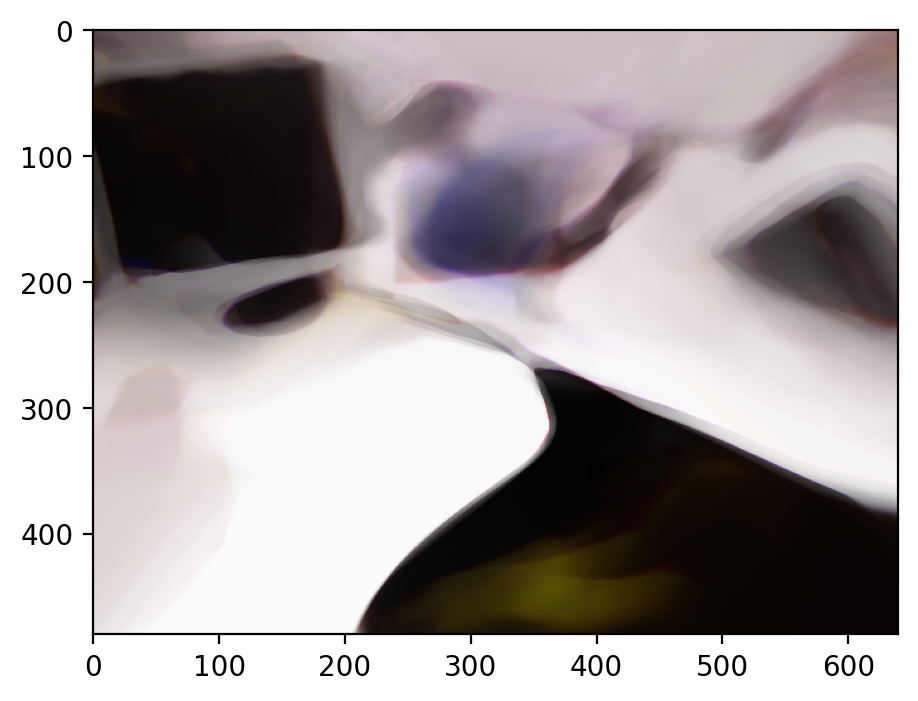

In [24]:
reconstructed_image = torch.cat(output_course_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

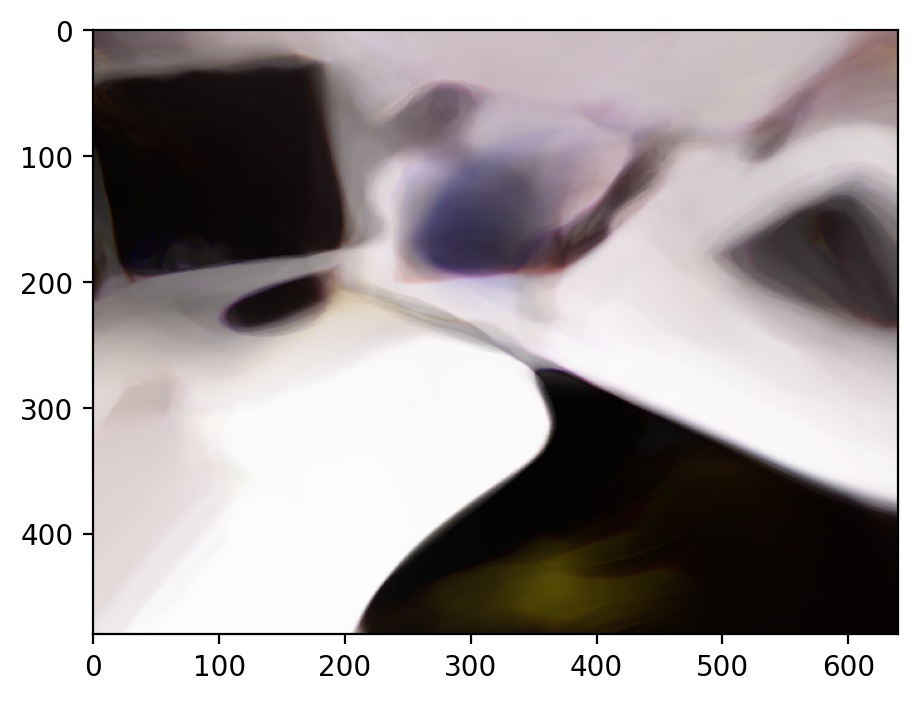

In [25]:
reconstructed_image = torch.cat(output_fine_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

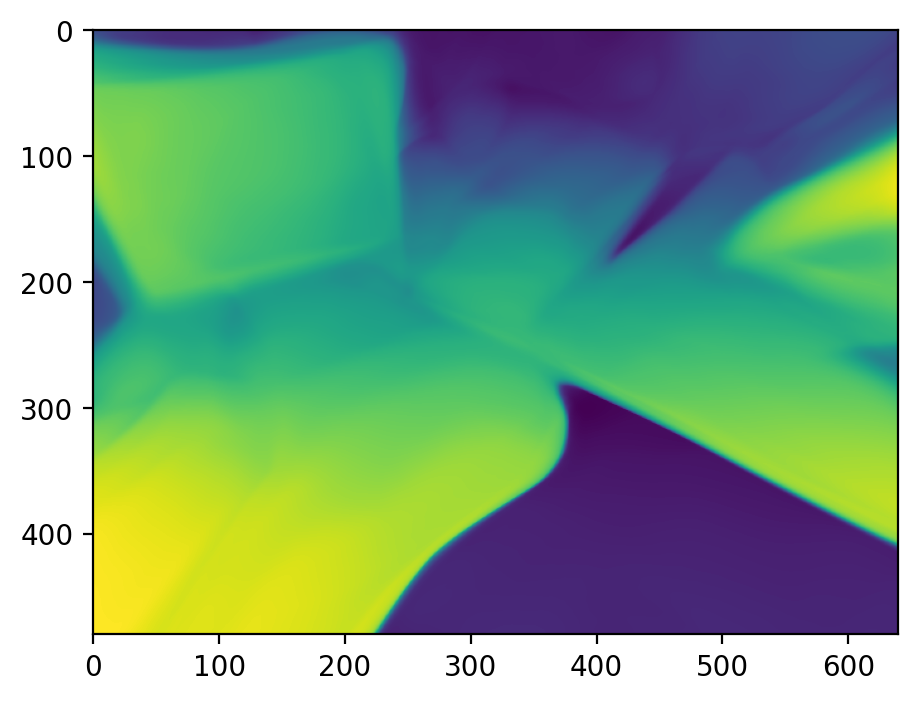

In [90]:
reconstructed_depth = torch.cat(output_course_depth, dim=0).reshape(480, 640).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

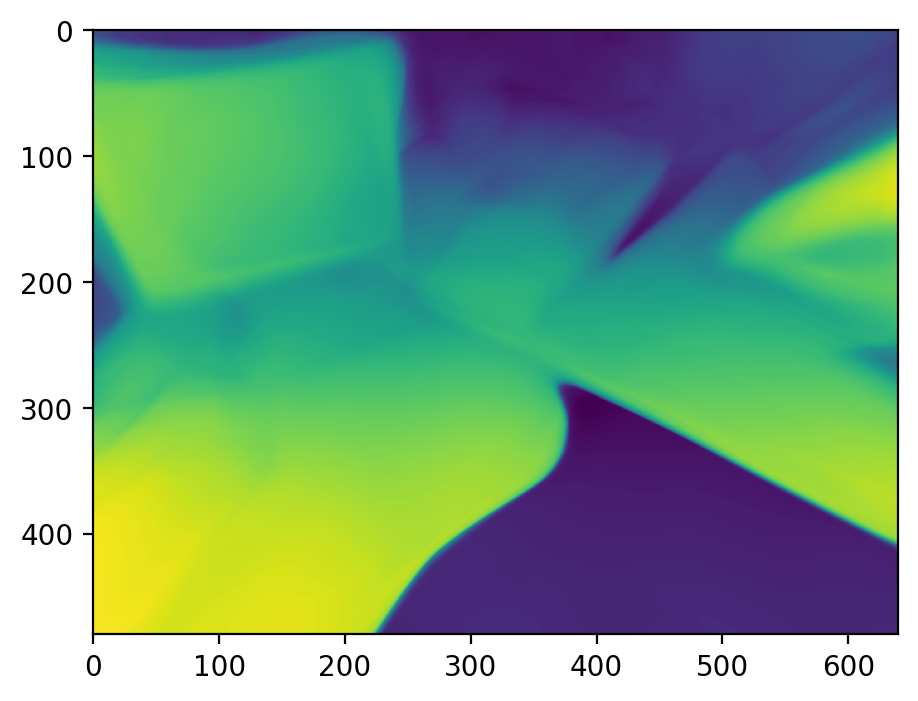

In [91]:
reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480, 640).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)